This notebook was written for the results described in the section 4.5.3 of the Master Thesis: Performance with Limited Training Data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
import pandas as pd

In [ ]:
final_df = pd.read_csv('training_dataframe.csv', index_col=0)
final_df = final_df.drop("n_relevant_entities", axis="columns")
final_df.head()

,graph_traverser,page_similarity_score,parent_similarity_score,entity_similarity_score,similarity_score,is_answer
130850,0,-0.245684,-4.524805,-4.524805,-4.524805,0
462661,0,-0.431245,-4.467841,-4.467841,-4.467841,0
367632,0,-4.230712,-4.230712,-0.425809,-4.230712,0
308468,0,0.176157,-4.528001,-4.528001,-4.528001,1
322238,0,-4.533956,-4.533956,-4.533956,0.030432,0


In [ ]:
# GET A SAMPLE OF 200 OBSERVATIONS
positive_obs = final_df[final_df['is_answer'] == 1]
positive_obs = positive_obs.sample(100, random_state=42)
negative_obs = final_df[final_df['is_answer'] == 0]
negative_obs = negative_obs.sample(100, random_state=42)
final_df = pd.concat([positive_obs, negative_obs])
final_df = final_df.sample(frac=1, random_state=42)
len(final_df)

200

In [54]:
y = final_df["is_answer"]
X = final_df.drop("is_answer", axis="columns")

In [55]:
tf.random.set_seed(42)

In [56]:
inputs = keras.Input((X.shape[1],))

x = inputs

x = keras.layers.Dense(254, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

        # Second hidden layer
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

        # Second hidden layer
x = keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)

        # Output layer
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
net = keras.Model(inputs, outputs)

In [57]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

In [58]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

history = net.fit(
        X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping,reduce_lr],
        verbose=1
    )

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 224ms/step - accuracy: 0.5203 - loss: 3.5324 - val_accuracy: 0.2500 - val_loss: 3.3358 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7793 - loss: 3.2436 - val_accuracy: 0.6500 - val_loss: 3.2476 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7859 - loss: 3.1667 - val_accuracy: 0.6750 - val_loss: 3.1905 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8496 - loss: 2.9425 - val_accuracy: 0.7250 - val_loss: 3.1449 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8086 - loss: 2.9719 - val_accuracy: 0.7250 - val_loss: 3.1023 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8062 - loss: 2.9363 - val_accuracy: 0.7250 - val_loss: 3.0586 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.8055 - loss: 2.9411 - val_accuracy:

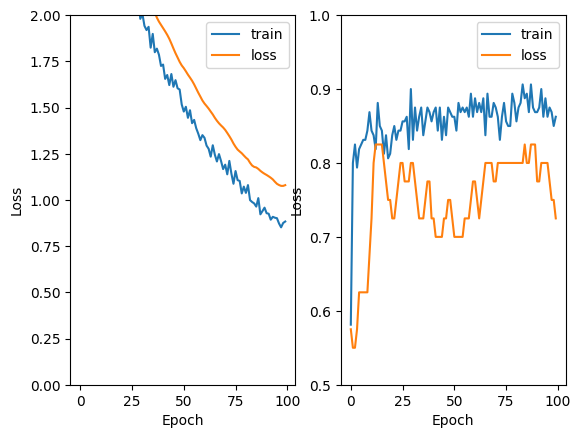

In [24]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

In [59]:
net.save("model_200_samples.keras")

In [25]:
col_order = ['graph_traverser', 'page_similarity_score', 'parent_similarity_score','entity_similarity_score', 'similarity_score']

In [26]:
import json

# Open and read the JSON file
with open('test_data.json', 'r') as file:
    test_data = json.load(file)

In [27]:
hybrid_precision = []
hybrid_recall = []
hybrid_detection = []

for question in tqdm(test_data):
    observations = question["observations"]
    # Check how many answers in total
    tot_answer = len([x for x in observations.values() if x.get("is_answer", 0) == 1])

    # Hybrid RAG retrieval: find top 3 chunks
    subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
    results = [x[0] for x in net.predict(subset, verbose=0)]
    top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:3]
    keys = [list(observations.keys())[x] for x in top_indexes]
    # Check how many of them cointain the answer
    found_answers = len([x for x in keys if observations[x].get("is_answer", 0) == 1])
    # Append results for Chunk RAG
    hybrid_precision.append(found_answers/3)
    hybrid_recall.append(found_answers/tot_answer)
    hybrid_detection.append(min(found_answers, 1))

100%|██████████| 1044/1044 [02:08<00:00,  8.10it/s]


In [28]:
print("PRECISION:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_precision)/len(hybrid_precision),2)}")
print("")
print("RECALL:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_recall)/len(hybrid_recall),2)}")
print("")
print("DETECTION:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_detection)/len(hybrid_detection),2)}")

PRECISION:
Hybrid RAG (200 training samples): 0.27

RECALL:
Hybrid RAG (200 training samples): 0.59

DETECTION:
Hybrid RAG (200 training samples): 0.68


# Smaller network

In [36]:
tf.random.set_seed(42)
inputs = keras.Input((X.shape[1],))

x = inputs

x = keras.layers.Dense(254, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)

        # Second hidden layer
x = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.3)(x)

        # Output layer
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
net = keras.Model(inputs, outputs)

In [37]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy'])

In [38]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

history = net.fit(
        X, y,
        epochs=100,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping,reduce_lr],
        verbose=1
    )

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 177ms/step - accuracy: 0.4840 - loss: 2.8641 - val_accuracy: 0.6250 - val_loss: 2.4157 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7605 - loss: 2.3121 - val_accuracy: 0.6250 - val_loss: 2.3495 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8023 - loss: 2.2790 - val_accuracy: 0.6500 - val_loss: 2.3021 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8195 - loss: 2.2776 - val_accuracy: 0.6500 - val_loss: 2.2622 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8395 - loss: 2.1805 - val_accuracy: 0.7000 - val_loss: 2.2313 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8445 - loss: 2.0985 - val_accuracy: 0.7500 - val_loss: 2.2093 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8289 - loss: 2.0492 - val_accuracy:

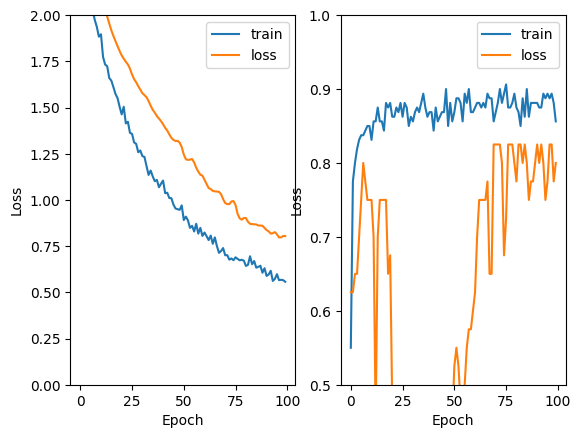

In [39]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train','loss'])

In [40]:
net.save("model2.keras")

In [41]:
hybrid_precision = []
hybrid_recall = []
hybrid_detection = []

for question in tqdm(test_data):
    observations = question["observations"]
    # Check how many answers in total
    tot_answer = len([x for x in observations.values() if x.get("is_answer", 0) == 1])

    # Hybrid RAG retrieval: find top 3 chunks
    subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
    results = [x[0] for x in net.predict(subset, verbose=0)]
    top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:3]
    keys = [list(observations.keys())[x] for x in top_indexes]
    # Check how many of them cointain the answer
    found_answers = len([x for x in keys if observations[x].get("is_answer", 0) == 1])
    # Append results for Chunk RAG
    hybrid_precision.append(found_answers/3)
    hybrid_recall.append(found_answers/tot_answer)
    hybrid_detection.append(min(found_answers, 1))

100%|██████████| 1044/1044 [02:26<00:00,  7.10it/s]


In [42]:
print("PRECISION:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_precision)/len(hybrid_precision),2)}")
print("")
print("RECALL:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_recall)/len(hybrid_recall),2)}")
print("")
print("DETECTION:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_detection)/len(hybrid_detection),2)}")

PRECISION:
Hybrid RAG (200 training samples): 0.25

RECALL:
Hybrid RAG (200 training samples): 0.56

DETECTION:
Hybrid RAG (200 training samples): 0.66


# Random Forest

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [44]:
def tune_random_forest(X, y, cv=5):
    # Define parameter grid
    param_grid = {
        # Number of trees in the forest
        'n_estimators': [100, 200, 300, 500],

        'criterion': ["gini", "entropy", "log_loss"],

        # Maximum depth of each tree
        'max_depth': [None, 10, 20],

        # Minimum samples required to split a node
        'min_samples_split': [2, 5, 10],

        # Minimum samples required at each leaf node
        'min_samples_leaf': [1, 2, 4],

        # Maximum number of features to consider for splits
        'max_features': ['sqrt', 'log2'],

        # Whether bootstrap samples are used
        #'bootstrap': [True, False]
    }

    # Initialize Random Forest
    rf = RandomForestClassifier(random_state=42)

    # Perform grid search
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        scoring='f1',
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X, y)

    # Get the best parameters and score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Get feature importances from the best model
    feature_importance = pd.DataFrame({
        'feature': [f'Feature_{i}' for i in range(X.shape[1])],
        'importance': grid_search.best_estimator_.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)

    return {
        'best_parameters': best_params,
        'best_score': best_score,
        'feature_importance': feature_importance,
        'cv_results': pd.DataFrame(grid_search.cv_results_)
    }

In [45]:
tune_random_forest(X,y)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


{'best_parameters': {'criterion': 'entropy',
  'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 5,
  'n_estimators': 200},
 'best_score': 0.8246420015354546,
 'feature_importance':      feature  importance
 4  Feature_4    0.316666
 2  Feature_2    0.272322
 1  Feature_1    0.240850
 3  Feature_3    0.115030
 0  Feature_0    0.055132,
 'cv_results':      mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
 0         0.297161      0.010491         0.020551        0.001285   
 1         0.539889      0.007781         0.036030        0.008907   
 2         0.814945      0.012759         0.042040        0.001464   
 3         1.746237      0.444247         0.096487        0.024895   
 4         0.459651      0.120171         0.031626        0.008307   
 ..             ...           ...              ...             ...   
 643       1.972972      0.362854         0.086173        0.024258   
 644       0.261099      0.008812         0.017

In [47]:
rf_model = RandomForestClassifier(random_state=42,
                            criterion= 'entropy',
                            max_depth= 10,
                            max_features= 'sqrt',
                            min_samples_leaf= 2,
                            min_samples_split= 5,
                            n_estimators= 200)
rf_model.fit(X,y)

RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=200, random_state=42)

In [48]:
hybrid_precision = []
hybrid_recall = []
hybrid_detection = []

for question in tqdm(test_data):
    observations = question["observations"]
    # Check how many answers in total
    tot_answer = len([x for x in observations.values() if x.get("is_answer", 0) == 1])

    # Hybrid RAG retrieval: find top 3 chunks
    subset = pd.DataFrame(observations.values()).drop("is_answer", axis="columns")[col_order]
    results = [x[1] for x in rf_model.predict_proba(subset)]
    top_indexes = sorted(range(len(results)), key=lambda k: results[k], reverse=True)[:3]
    keys = [list(observations.keys())[x] for x in top_indexes]
    # Check how many of them cointain the answer
    found_answers = len([x for x in keys if observations[x].get("is_answer", 0) == 1])
    # Append results for Chunk RAG
    hybrid_precision.append(found_answers/3)
    hybrid_recall.append(found_answers/tot_answer)
    hybrid_detection.append(min(found_answers, 1))

100%|██████████| 1044/1044 [00:25<00:00, 41.50it/s]


In [49]:
print("PRECISION:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_precision)/len(hybrid_precision),2)}")
print("")
print("RECALL:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_recall)/len(hybrid_recall),2)}")
print("")
print("DETECTION:")
print(f"Hybrid RAG (200 training samples): {round(sum(hybrid_detection)/len(hybrid_detection),2)}")

PRECISION:
Hybrid RAG (200 training samples): 0.22

RECALL:
Hybrid RAG (200 training samples): 0.47

DETECTION:
Hybrid RAG (200 training samples): 0.57
